In [1]:
!gdown --id 1lBvEFEGAIV0bywpIhROoNbAfllcqgdpa
!unzip /content/seq2seq.zip
%cd "/content/LAB2_Seq2seq + Attn"
import nltk
nltk.download("punkt")

Downloading...
From: https://drive.google.com/uc?id=1lBvEFEGAIV0bywpIhROoNbAfllcqgdpa
To: /content/seq2seq.zip
5.88MB [00:00, 51.8MB/s]
Archive:  /content/seq2seq.zip
   creating: LAB2_Seq2seq + Attn/
   creating: LAB2_Seq2seq + Attn/.vscode/
  inflating: LAB2_Seq2seq + Attn/.vscode/settings.json  
  inflating: LAB2_Seq2seq + Attn/requirements.txt  
  inflating: LAB2_Seq2seq + Attn/Report.pdf  
   creating: LAB2_Seq2seq + Attn/data/
  inflating: LAB2_Seq2seq + Attn/data/pairs_test_ints.txt  
  inflating: LAB2_Seq2seq + Attn/data/pairs_train_ints.txt  
  inflating: LAB2_Seq2seq + Attn/data/vocab_target.json  
  inflating: LAB2_Seq2seq + Attn/data/vocab_source.json  
  inflating: LAB2_Seq2seq + Attn/data/README.txt  
   creating: LAB2_Seq2seq + Attn/models/
  inflating: LAB2_Seq2seq + Attn/models/pretrained_moodle.pt  
   creating: LAB2_Seq2seq + Attn/code/
   creating: LAB2_Seq2seq + Attn/code/__pycache__/
  inflating: LAB2_Seq2seq + Attn/code/__pycache__/model.cpython-37.pyc  
  inflat

True

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm

from nltk import word_tokenize

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np 

class Encoder(nn.Module):
    '''
    to be passed the entire source sequence at once
    we use padding_idx in nn.Embedding so that the padding vector does not take gradient (always zero)
    https://pytorch.org/docs/stable/nn.html#gru
    '''
    def __init__(self, vocab_size, embedding_dim, hidden_dim, padding_idx):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim)
    
    def forward(self, input):
        # fill the gaps # (transform input into embeddings and pass embeddings to RNN)
        # you should return a tensor of shape (seq,batch,feat)
        emb = self.embedding(input)
        out,hs = self.rnn(emb)
        
        #return out,hs.data
        return out
    
class seq2seqAtt(nn.Module):
    '''
    concat global attention a la Luong et al. 2015 (subsection 3.1)
    https://arxiv.org/pdf/1508.04025.pdf
    '''
    def __init__(self, hidden_dim, hidden_dim_s, hidden_dim_t):
        super(seq2seqAtt, self).__init__()
        self.ff_concat = nn.Linear(hidden_dim_s+hidden_dim_t,hidden_dim)
        self.ff_score = nn.Linear(hidden_dim,1,bias=False) # just a dot product here
    
    def forward(self,target_h,source_hs):
        target_h_rep = target_h.repeat(source_hs.size(0),1,1) # (1,batch,feat) -> (seq,batch,feat)
        # fill the gaps #
        # implement the score computation part of the concat formulation (see section 3.1. of Luong 2015)
        concat_vec = torch.cat([target_h_rep,source_hs],axis=2)
        concat_output = torch.tanh(self.ff_concat(concat_vec))
        scores = self.ff_score(concat_output) # should be of shape (seq,batch,1)
        scores = scores.squeeze(dim=2) # (seq,batch,1) -> (seq,batch). dim=2 because we don't want to squeeze the batch dim if batch size = 1
        norm_scores = torch.softmax(scores,0)
        source_hs_p = source_hs.permute((2,0,1)) # (seq,batch,feat) -> (feat,seq,batch)
        weighted_source_hs = (norm_scores * source_hs_p) # (seq,batch) * (feat,seq,batch) (* checks from right to left that the dimensions match)
        ct = torch.sum(weighted_source_hs.permute((1,2,0)),0,keepdim=True) # (feat,seq,batch) -> (seq,batch,feat) -> (1,batch,feat); keepdim otherwise sum squeezes 
        return ct,norm_scores


class Decoder(nn.Module):
    '''to be used one timestep at a time
       see https://pytorch.org/docs/stable/nn.html#gru'''
    def __init__(self, vocab_size, embedding_dim, hidden_dim, padding_idx):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim)
        self.ff_concat = nn.Linear(2*hidden_dim,hidden_dim)
        self.predict = nn.Linear(hidden_dim, vocab_size)
        self.softmax = torch.nn.Softmax(dim=2)
    
    def forward(self, input, source_context, h):
        # fill the gaps #
        # transform input into embeddings, pass embeddings to RNN, concatenate with source_context and apply tanh, and make the prediction
        # prediction should be of shape (1,batch,vocab), h and tilde_h of shape (1,batch,feat)
        emb    = self.embedding(input)
        rnn_out,rnn_hidden = self.rnn(emb,h)
        concat = torch.cat([source_context,rnn_hidden],axis=2)
        dense  = torch.tanh(self.ff_concat(concat))
        #prediction = self.softmax(self.predict(dense))
        prediction = self.predict(dense)

        return prediction, rnn_hidden


class seq2seqModel(nn.Module):
    '''the full seq2seq model'''
    ARGS = ['vocab_s','source_language','vocab_t_inv','embedding_dim_s','embedding_dim_t',
     'hidden_dim_s','hidden_dim_t','hidden_dim_att','do_att','padding_token',
     'oov_token','sos_token','eos_token','max_size','eos','teacher_forcing']
    def __init__(self, vocab_s, source_language, vocab_t_inv, embedding_dim_s, embedding_dim_t, 
                 hidden_dim_s, hidden_dim_t, hidden_dim_att, do_att, padding_token,
                 oov_token, sos_token, eos_token, max_size,teacher_forcing,eos):
        super().__init__()
        self.vocab_s = vocab_s
        self.source_language = source_language
        self.vocab_t_inv = vocab_t_inv
        self.embedding_dim_s = embedding_dim_s
        self.embedding_dim_t = embedding_dim_t
        self.hidden_dim_s = hidden_dim_s
        self.hidden_dim_t = hidden_dim_t
        self.hidden_dim_att = hidden_dim_att
        self.do_att = do_att # should attention be used?
        self.padding_token = padding_token
        self.oov_token = oov_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.max_size = max_size
        self.teacher_forcing = teacher_forcing
        self.eos = eos
        
        self.max_source_idx = max(list(vocab_s.values()))
        print('max source index',self.max_source_idx)
        print('source vocab size',len(vocab_s))
        
        self.max_target_idx = max([int(elt) for elt in list(vocab_t_inv.keys())])
        print('max target index',self.max_target_idx)
        print('target vocab size',len(vocab_t_inv))
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.encoder = Encoder(self.max_source_idx+1,self.embedding_dim_s,self.hidden_dim_s,self.padding_token).to(self.device)
        self.decoder = Decoder(self.max_target_idx+1,self.embedding_dim_t,self.hidden_dim_t,self.padding_token).to(self.device)
        
        if self.do_att:
            self.att_mech = seq2seqAtt(self.hidden_dim_att,self.hidden_dim_s,self.hidden_dim_t).to(self.device)

        self.name = self.do_att * '_att_'+ self.teacher_forcing * "_tf"+ (not self.eos)*'_no_eos'
    
    def my_pad(self,my_list):
        '''my_list is a list of tuples of the form [(tensor_s_1,tensor_t_1),...,(tensor_s_batch,tensor_t_batch)]
        the <eos> token is appended to each sequence before padding
        https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pad_sequence'''

        if self.eos : 
          batch_source = pad_sequence([torch.cat((elt[0],torch.LongTensor([self.eos_token]))) for elt in my_list],batch_first=True,padding_value=self.padding_token)
          batch_target = pad_sequence([torch.cat((elt[1],torch.LongTensor([self.eos_token]))) for elt in my_list],batch_first=True,padding_value=self.padding_token)

          #print(batch_target.size())

        else:

          batch_source = pad_sequence([elt[0] for elt in my_list],batch_first=True,padding_value=self.padding_token)
          batch_target = pad_sequence([elt[1] for elt in my_list],batch_first=True,padding_value=self.padding_token)
          #print(batch_target.size())

        return batch_source,batch_target
    
    def forward(self,input,max_size,is_prod):
        
        if is_prod: 
            input = input.unsqueeze(1) # (seq) -> (seq,1) 1D input <=> we receive just one sentence as input (predict/production mode)
        
        current_batch_size = input.size(1)
    
        # fill the gap #
        # use the encoder
        source_hs= self.encoder(input)
        
        
        # = = = decoder part (one timestep at a time)  = = =
        
        target_h = torch.zeros(size=(1,current_batch_size,self.hidden_dim_t)).to(self.device) # init (1,batch,feat)
        
        # fill the gap #
        # (initialize target_input with the proper token)
        target_input = torch.LongTensor([self.sos_token]).repeat(current_batch_size).unsqueeze(0).to(self.device) # init (1,batch)
        
        pos = 0
        eos_counter = 0
        logits = []
        scores = []
        
        
        while True:
            
            if self.do_att:
                source_context,word_scores = self.att_mech(target_h,source_hs) # (1,batch,feat)
            else:
                source_context = source_hs[-1,:,:].unsqueeze(0) # (1,batch,feat) last hidden state of encoder
            
            # fill the gap #
            # use the decoder
            prediction, target_h = self.decoder(target_input,source_context,target_h)
            
            logits.append(prediction) # (1,batch,vocab)
            #attention_scores.append(scores)
            if self.do_att :
              scores.append(word_scores.squeeze().cpu().detach().numpy())

            
            # fill the gap #
            # get the next input to pass the decoder
            if self.teacher_forcing:
              if pos < input.size()[0]:
                target_input = input[pos].unsqueeze(0)
              else : 
                 target_input = input[-1].unsqueeze(0)
              
            else :
              target_input = torch.argmax(prediction,axis=2)
              
            
            eos_counter += torch.sum(target_input==self.eos_token).item()
            
            pos += 1
            if pos>=max_size or (eos_counter == current_batch_size and is_prod):
                break

        
        to_return = torch.cat(logits,0) # logits is a list of tensors -> (seq,batch,vocab)
        
        if is_prod:
            to_return = to_return.squeeze(dim=1) # (seq,vocab)
            #print("return shape",to_return.shape)
            #print("scores shape",sentence_scores.T.shape)
            #print("Sentence attention score shape",sentence_scores.T.size())
            #print("Sentence attention",sentence_scores)
            return to_return,scores
        
        return to_return
    
    def fit(self, trainingDataset, testDataset, lr, batch_size,n_epochs, patience):
   
        loss = []

        parameters = [p for p in self.parameters() if p.requires_grad]
        
        optimizer = optim.Adam(parameters, lr=lr)
        #optimizer = optim.SGD(parameters,lr=0.01,momentum=0.9)
        
        criterion = torch.nn.CrossEntropyLoss(ignore_index=self.padding_token) # the softmax is inside the loss!
        
        # https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
        # we pass a collate function to perform padding on the fly, within each batch
        # this is better than truncation/padding at the dataset level
        train_loader = data.DataLoader(trainingDataset, batch_size=batch_size, 
                                       shuffle=True, collate_fn=self.my_pad) # returns (batch,seq)
        
        test_loader = data.DataLoader(testDataset, batch_size=512,
                                      collate_fn=self.my_pad)
        
        tdqm_dict_keys = ['loss', 'test loss']
        tdqm_dict = dict(zip(tdqm_dict_keys,[0.0,0.0]))
        
        patience_counter = 1
        patience_loss = 99999
        test_loss = 0
        train_loss = 0
        
        for epoch in range(n_epochs):
                   
            with tqdm(total=len(train_loader),unit_scale=True,postfix={'loss':0.0,'test loss':0.0},
                      desc="Epoch : %i/%i" % (epoch, n_epochs-1),ncols=100) as pbar:
                for loader_idx, loader in enumerate([train_loader, test_loader]):
                    total_loss = 0
                    # set model mode (https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
                    if loader_idx == 0:
                        self.train()
                    else:
                        self.eval()
                    for i, (batch_source,batch_target) in enumerate(loader):
                        batch_source = batch_source.transpose(1,0).to(self.device) # RNN needs (seq,batch,feat) but loader returns (batch,seq)                        
                        batch_target = batch_target.transpose(1,0).to(self.device) # (seq,batch)
                        
                        # are we using the model in production / as an API?
                        is_prod = len(batch_source.shape)==1 # if False, 2D input (seq,batch), i.e., train or test
                        
                        if is_prod:
                            max_size = self.max_size
                            self.eval()
                        else:
                            max_size = batch_target.size(0) # no need to continue generating after we've exceeded the length of the longest ground truth sequence
                        
                        unnormalized_logits = self.forward(batch_source,max_size,is_prod)

                        sentence_loss = criterion(unnormalized_logits.flatten(end_dim=1),batch_target.flatten())

                        total_loss += sentence_loss.item()

                        
                        tdqm_dict[tdqm_dict_keys[loader_idx]] = total_loss/(i+1)

                
                        
                        pbar.set_postfix(tdqm_dict)


                        
                        if loader_idx == 0:
                            optimizer.zero_grad() # flush gradient attributes
                            sentence_loss.backward() # compute gradients
                            optimizer.step() # update
                            pbar.update(1)
                            train_loss = total_loss/(i+1)
                        else :
                            test_loss = total_loss/(i+1)
            
            if total_loss > patience_loss:
                patience_counter += 1
            else:
                patience_loss = total_loss
                patience_counter = 1 # reset
            
            if patience_counter>patience:
                break
            
            loss.append([train_loss,test_loss])
      
        print("SAVING FIIIILE")
        path_root = '/content/LAB2_Seq2seq + Attn/models/'
        np.savetxt(path_root +'experiment' + self.name +".txt",np.array(loss))

            
    
    def sourceNl_to_ints(self,source_nl):
        '''converts natural language source sentence into source integers'''
        source_nl_clean = source_nl.lower().replace("'",' ').replace('-',' ')
        source_nl_clean_tok = word_tokenize(source_nl_clean,self.source_language)
        source_ints = [int(self.vocab_s[elt]) if elt in self.vocab_s else \
                       self.oov_token for elt in source_nl_clean_tok]
        
        source_ints = torch.LongTensor(source_ints).to(self.device)
        return source_ints 
    
    def targetInts_to_nl(self,target_ints):
        '''converts integer target sentence into target natural language'''
        return ['<PAD>' if elt==self.padding_token else '<OOV>' if elt==self.oov_token \
                else '<EOS>' if elt==self.eos_token else '<SOS>' if elt==self.sos_token\
                else self.vocab_t_inv[elt] for elt in target_ints]
    
    def predict(self,source_nl):
        source_ints = self.sourceNl_to_ints(source_nl)
        logits,attention_sentence = self.forward(source_ints,self.max_size,True) # (seq) -> (<=max_size,vocab)
        target_ints = logits.argmax(-1).squeeze() # (<=max_size,1) -> (<=max_size)
        target_nl = self.targetInts_to_nl(target_ints.tolist())
        
        ##### PLOT FUNCTION #####
        if self.do_att:
      
      
          fig = plt.figure(figsize = (10,10))        
          ax = fig.add_subplot(111)
          
          
          for i,word in enumerate(target_nl):
              if word == '.':
                  target_nl = target_nl[:i]
                  attention_sentence = attention_sentence [:i]
                  break
              
          scores = attention_sentence
          ax.imshow(scores, cmap='hot')
          
          # Set up axes
          ax.set_xticklabels(['']+ source_nl.split(' ') +
                        ['<EOS>'], rotation=90)
          ax.set_yticklabels([''] + target_nl )
          
          # Show label at every tick
          ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
          ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
          

          fig.savefig('attention_evaluation.png')
        ###########END PLOT FUNCTION ###########
          
        return ' '.join(target_nl)
 
    
        
    def save(self,path_to_file):
        attrs = {attr:getattr(self,attr) for attr in self.ARGS}
        attrs['state_dict'] = self.state_dict()
        torch.save(attrs,path_to_file)
    
    @classmethod # a class method does not see the inside of the class (a static method does not take self as first argument)
    def load(cls,path_to_file):

        attrs = torch.load(path_to_file, map_location=lambda storage, loc: storage) # allows loading on CPU a model trained on GPU, see https://discuss.pytorch.org/t/on-a-cpu-device-how-to-load-checkpoint-saved-on-gpu-device/349/6
        print("attrs=",attrs.keys())
        
        state_dict = attrs.pop('state_dict')
        new = cls(**attrs) # * list and ** names (dict) see args and kwargs
        new.load_state_dict(state_dict)
        return new        

In [5]:
import sys
import json

import torch
from torch.utils import data

# = = = = = = = = = = =

path_root = '/content/LAB2_Seq2seq + Attn/'
#path_root = "/home/mahdo/Desktop/ALTEGRAD_LABS/LAB2_Seq2seq + Attn/"

path_to_model = path_root + '/code/'
sys.path.insert(0, path_to_model)



path_to_data = path_root + 'data/'
path_to_save_models = path_root + 'models/'

# = = = = = = = = = = =

class Dataset(data.Dataset):
  def __init__(self, pairs):
        self.pairs = pairs

  def __len__(self):
        return len(self.pairs) # total nb of observations

  def __getitem__(self, idx):
        source, target = self.pairs[idx] # one observation
        return torch.LongTensor(source), torch.LongTensor(target)


def load_pairs(train_or_test):
    with open(path_to_data + 'pairs_' + train_or_test + '_ints.txt', 'r', encoding='utf-8') as file:
        pairs_tmp = file.read().splitlines()
    pairs_tmp = [elt.split('\t') for elt in pairs_tmp]
    pairs_tmp = [[[int(eltt) for eltt in elt[0].split()],[int(eltt) for eltt in \
                  elt[1].split()]] for elt in pairs_tmp]
    return pairs_tmp


# = = = = = = = = = = =

def experiment(is_prod,do_att,do_tf,eos,n_epochs=1):

# do_att = True # should always be set to True
# is_prod = False  # production mode or not>

  model_name = do_att * '_att_'+ do_tf * "_tf"+ (not eos)*'_no_eos'

  if not is_prod:
          
      pairs_train = load_pairs('train')
      pairs_test = load_pairs('test')
      
      with open(path_to_data + 'vocab_source.json','r') as file:
          vocab_source = json.load(file) # word -> index
      
      with open(path_to_data + 'vocab_target.json','r') as file:
          vocab_target = json.load(file) # word -> index
      
      vocab_target_inv = {v:k for k,v in vocab_target.items()} # index -> word
      
      print('data loaded')
          
      training_set = Dataset(pairs_train)
      test_set = Dataset(pairs_test)
      
      print('data prepared')
      
      print('= = = attention-based model?:',str(do_att),'= = =')
      
      model = seq2seqModel(vocab_s=vocab_source,
                          source_language='english',
                          vocab_t_inv=vocab_target_inv,
                          embedding_dim_s=40,
                          embedding_dim_t=40,
                          hidden_dim_s=30,
                          hidden_dim_t=30,
                          hidden_dim_att=20,
                          do_att=do_att,
                          padding_token=0,
                          oov_token=1,
                          sos_token=2,
                          eos_token=3,
                          max_size=30,
                          teacher_forcing=do_tf,
                          eos=eos) # max size of generated sentence in prediction mode
      
      model.fit(training_set,test_set,lr=0.01,batch_size=128,n_epochs=n_epochs,patience=2)
      model.save(path_to_save_models + 'model_'+model.name +'.pt')

  else:
      
      #model = seq2seqModel.load(path_to_save_models + 'pretrained_moodle.pt')
      model = seq2seqModel.load(path_to_save_models + "model_"+model_name+'.pt')
      
      to_test = ['I am a student.',
                'I have a red car.',  # inversion captured
                'I love playing video games.',
                  'This river is full of fish.', # plein vs pleine (accord)
                  'The fridge is full of food.',
                'The cat fell asleep on the mat.',
                'my brother likes pizza.', # pizza is translated to 'la pizza'
                'I did not mean to hurt you', # translation of mean in context
                'She is so mean',
                'Help me pick out a tie to go with this suit!', # right translation
                "I can't help but smoking weed", # this one and below: hallucination
                'The kids were playing hide and seek',
                'The cat fell asleep in front of the fireplace']
      
      for elt in to_test:
          print('= = = = = \n','%s -> %s' % (elt,model.predict(elt)))


In [17]:
experiment(is_prod=False,do_att=True,do_tf=True,eos=True,n_epochs=15)
experiment(is_prod=False,do_att=True,do_tf=False,eos=True,n_epochs=15)
experiment(is_prod=False,do_att=False,do_tf=False,eos=True,n_epochs=15)
experiment(is_prod=False,do_att=True,do_tf=False,eos=False,n_epochs=15)


Epoch : 0/14:   0%|                     | 3.00/1.07k [00:00<00:56, 18.9it/s, loss=8.71, test loss=0]

data loaded
data prepared
= = = attention-based model?: False = = =
max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456


Epoch : 0/14: 100%|█████████████████| 1.07k/1.07k [00:55<00:00, 19.2it/s, loss=4.87, test loss=4.28]
Epoch : 1/14: 100%|█████████████████| 1.07k/1.07k [00:55<00:00, 19.2it/s, loss=4.06, test loss=3.87]
Epoch : 2/14: 100%|██████████████████| 1.07k/1.07k [00:57<00:00, 18.5it/s, loss=3.77, test loss=3.7]
Epoch : 3/14: 100%|█████████████████| 1.07k/1.07k [00:55<00:00, 19.3it/s, loss=3.59, test loss=3.56]
Epoch : 4/14: 100%|█████████████████| 1.07k/1.07k [00:56<00:00, 19.0it/s, loss=3.47, test loss=3.47]
Epoch : 5/14: 100%|█████████████████| 1.07k/1.07k [00:55<00:00, 19.1it/s, loss=3.38, test loss=3.42]
Epoch : 6/14: 100%|█████████████████| 1.07k/1.07k [00:57<00:00, 18.5it/s, loss=3.32, test loss=3.39]
Epoch : 7/14: 100%|█████████████████| 1.07k/1.07k [00:56<00:00, 18.8it/s, loss=3.28, test loss=3.35]
Epoch : 8/14: 100%|█████████████████| 1.07k/1.07k [00:56<00:00, 18.9it/s, loss=3.24, test loss=3.31]
Epoch : 9/14: 100%|█████████████████| 1.07k/1.07k [00:55<00:00, 19.3it/s, loss=3.21, test l

SAVING FIIIILE


Epoch : 0/14:   0%|                     | 2.00/1.07k [00:00<01:08, 15.6it/s, loss=8.83, test loss=0]

data loaded
data prepared
= = = attention-based model?: True = = =
max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456


Epoch : 0/14: 100%|█████████████████| 1.07k/1.07k [01:12<00:00, 14.7it/s, loss=4.63, test loss=3.84]
Epoch : 1/14: 100%|█████████████████| 1.07k/1.07k [01:12<00:00, 14.7it/s, loss=3.55, test loss=3.36]
Epoch : 2/14: 100%|█████████████████| 1.07k/1.07k [01:11<00:00, 14.9it/s, loss=3.17, test loss=3.15]
Epoch : 3/14: 100%|████████████████████| 1.07k/1.07k [01:12<00:00, 14.8it/s, loss=2.98, test loss=3]
Epoch : 4/14: 100%|█████████████████| 1.07k/1.07k [01:11<00:00, 14.9it/s, loss=2.86, test loss=2.93]
Epoch : 5/14: 100%|█████████████████| 1.07k/1.07k [01:11<00:00, 14.9it/s, loss=2.78, test loss=2.87]
Epoch : 6/14: 100%|█████████████████| 1.07k/1.07k [01:11<00:00, 14.9it/s, loss=2.72, test loss=2.84]
Epoch : 7/14: 100%|█████████████████| 1.07k/1.07k [01:11<00:00, 14.9it/s, loss=2.68, test loss=2.81]
Epoch : 8/14: 100%|█████████████████| 1.07k/1.07k [01:11<00:00, 14.8it/s, loss=2.64, test loss=2.78]
Epoch : 9/14: 100%|█████████████████| 1.07k/1.07k [01:12<00:00, 14.7it/s, loss=2.61, test l

SAVING FIIIILE


experiment_att__tf.txt
experiment.txt
experiment_att__no_eos.txt
experiment_att_.txt


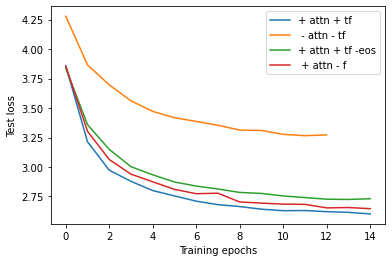

In [47]:
import os
import matplotlib.pyplot as plt

path = "/content/LAB2/models/"
files =[]
for file in os.listdir(path):
  if "experiment" in file: 
    print(file)
    files.append(path+file)

exps = [np.loadtxt(file) for file in files]


labels = ["+ attn + tf", " - attn - tf","+ attn + tf -eos"," + attn - f"]
for i,xp in enumerate(exps):
  x = range(len(xp[:,0]))
  
  plt.plot(x,xp[:,1],label=labels[i])

plt.xlabel("Training epochs")
plt.ylabel("Test loss")
plt.legend()
plt.show()
  




attrs= dict_keys(['vocab_s', 'source_language', 'vocab_t_inv', 'embedding_dim_s', 'embedding_dim_t', 'hidden_dim_s', 'hidden_dim_t', 'hidden_dim_att', 'do_att', 'padding_token', 'oov_token', 'sos_token', 'eos_token', 'max_size', 'eos', 'teacher_forcing', 'state_dict'])
max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456
= = = = = 
 I am a student. -> je suis étudiant étudiant
= = = = = 
 I have a red car. -> j ai une rouge rouge
= = = = = 
 I love playing video games. -> j adore jouer jeux jeux jeux jeux jeux
= = = = = 
 This river is full of fish. -> cette rivière est plein de
= = = = = 
 The fridge is full of food. -> le frigo est plein de de
= = = = = 
 The cat fell asleep on the mat. -> le chat est endormit endormi sur le
= = = = = 
 my brother likes pizza. -> mon frère adore collectionner pizza
= = = = = 
 I did not mean to hurt you -> je n ai pas que dire blesser blesser blesser vous vous
= = = = = 
 She is so mean -> elle est aussi dire dire

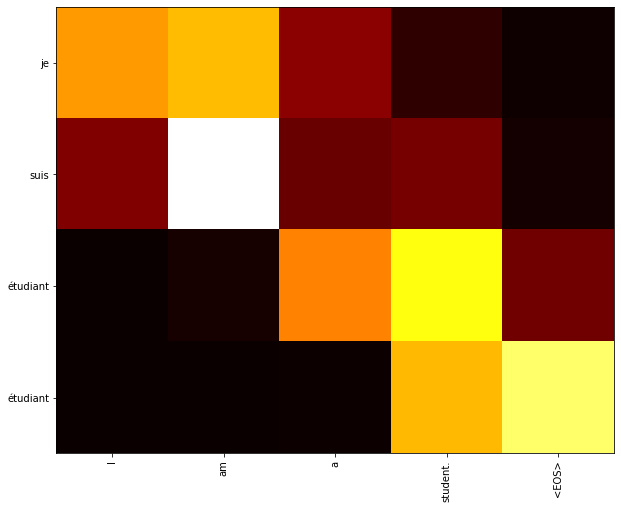

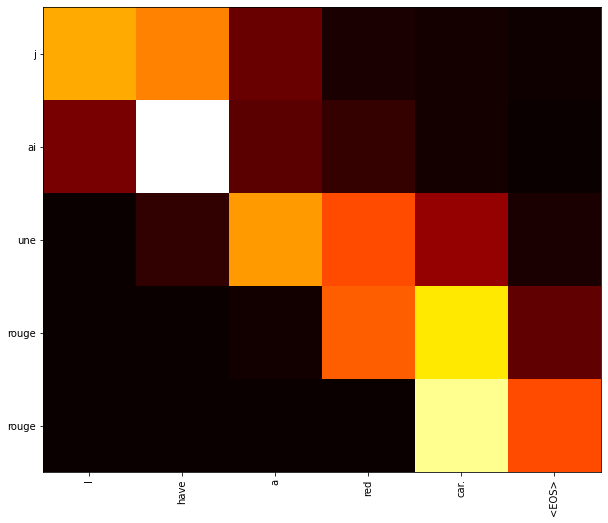

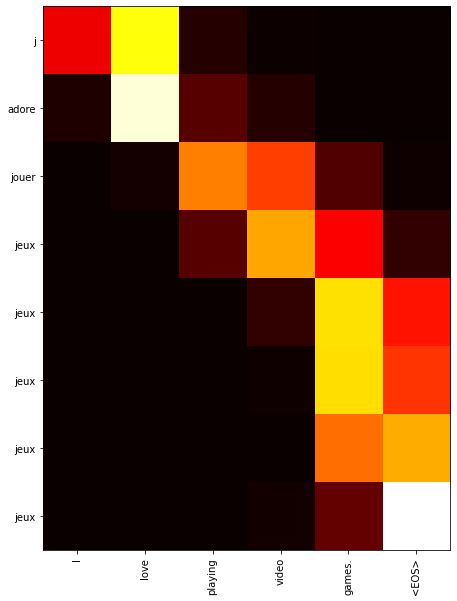

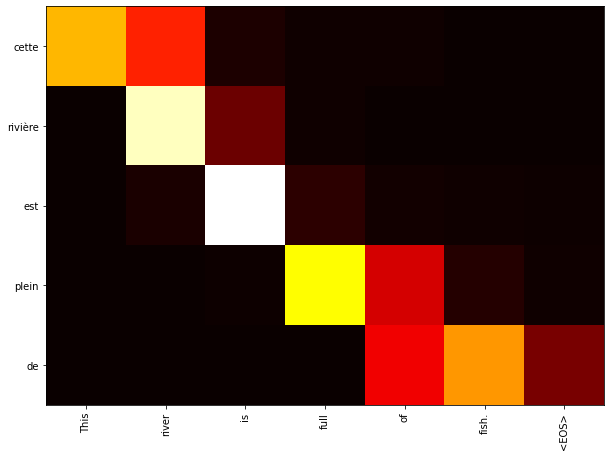

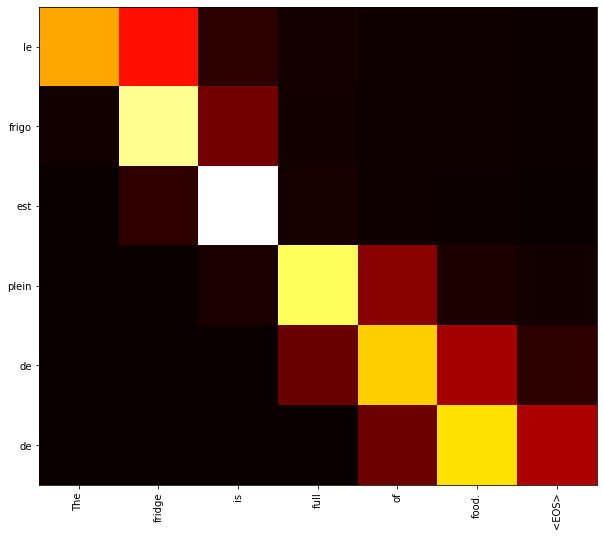

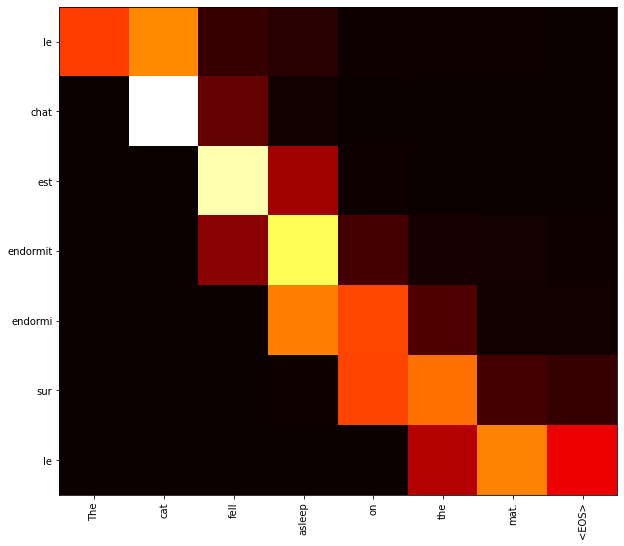

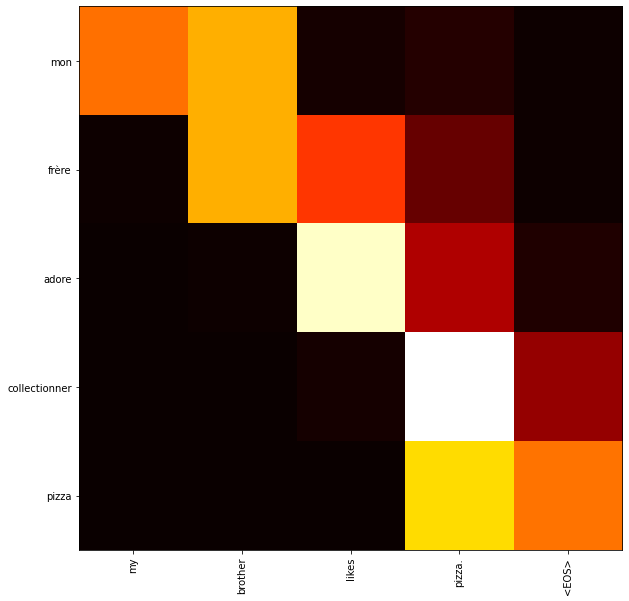

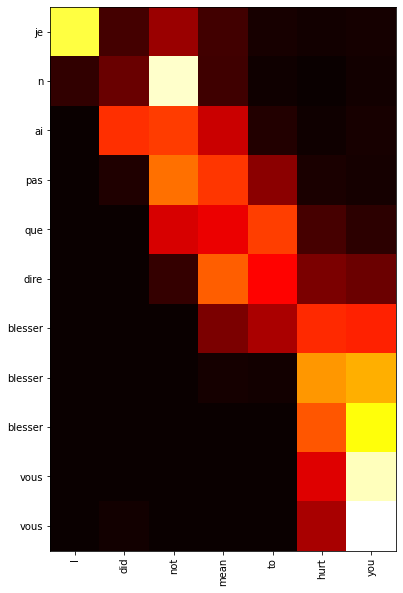

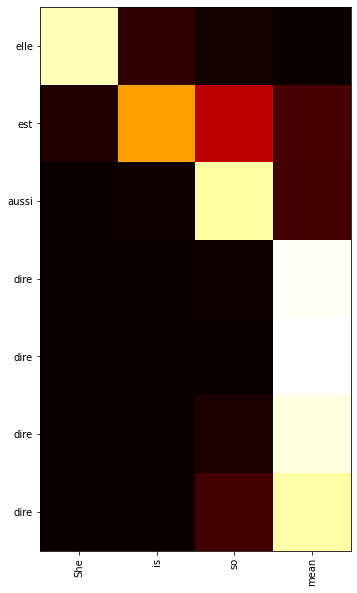

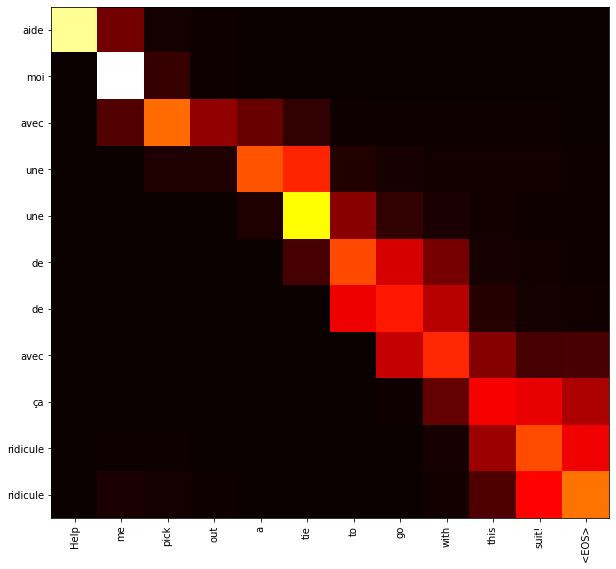

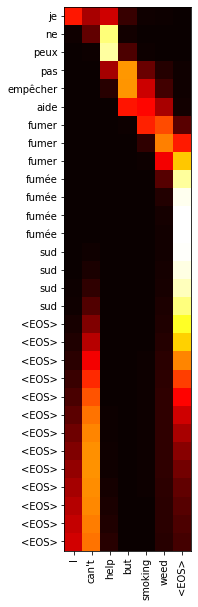

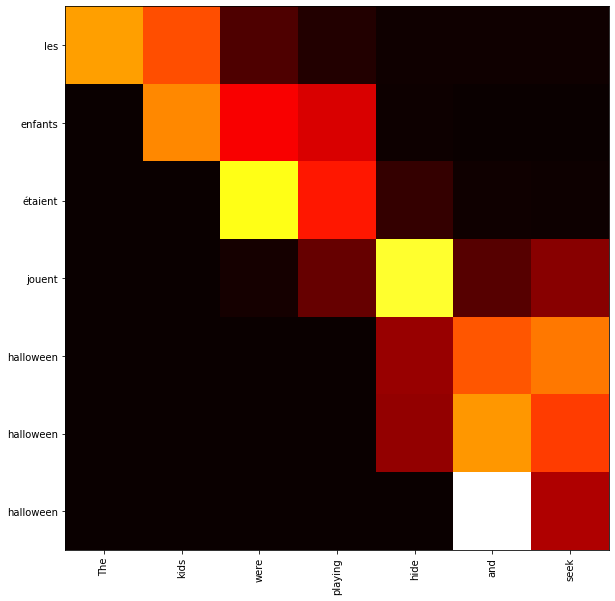

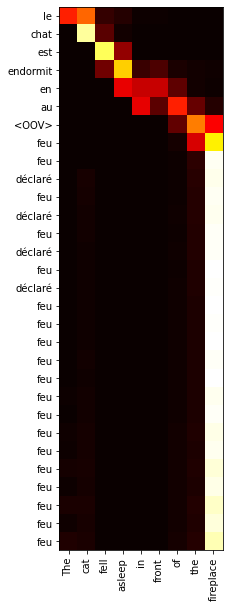

In [31]:
experiment(is_prod=True,do_att=True,do_tf=True,eos=True,n_epochs=15)


In [49]:
experiment(is_prod=True,do_att=True,do_tf=False,eos=True,n_epochs=15)


FileNotFoundError: ignored

In [33]:
experiment(is_prod=True,do_att=False,do_tf=False,eos=True,n_epochs=15)



attrs= dict_keys(['vocab_s', 'source_language', 'vocab_t_inv', 'embedding_dim_s', 'embedding_dim_t', 'hidden_dim_s', 'hidden_dim_t', 'hidden_dim_att', 'do_att', 'padding_token', 'oov_token', 'sos_token', 'eos_token', 'max_size', 'eos', 'teacher_forcing', 'state_dict'])
max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456
= = = = = 
 I am a student. -> je suis étudiant étudiant étudiant <EOS>
= = = = = 
 I have a red car. -> j ai une une voiture voiture . <EOS>
= = = = = 
 I love playing video games. -> j aime aime vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo vidéo
= = = = = 
 This river is full of fish. -> cette poisson est une la la la . . <EOS>
= = = = = 
 The fridge is full of food. -> le la est la la la la . <EOS>
= = = = = 
 The cat fell asleep on the mat. -> le chat est endormi la la la . . . <EOS>
= = = = = 
 my brother likes pizza. 

attrs= dict_keys(['vocab_s', 'source_language', 'vocab_t_inv', 'embedding_dim_s', 'embedding_dim_t', 'hidden_dim_s', 'hidden_dim_t', 'hidden_dim_att', 'do_att', 'padding_token', 'oov_token', 'sos_token', 'eos_token', 'max_size', 'eos', 'teacher_forcing', 'state_dict'])
max source index 5281
source vocab size 5278
max target index 7459
target vocab size 7456
= = = = = 
 I am a student. -> je suis étudiant étudiant
= = = = = 
 I have a red car. -> j ai une voiture voiture
= = = = = 
 I love playing video games. -> j adore jouer de jeux jeux jeux jeux jeux principes
= = = = = 
 This river is full of fish. -> cette rivière est une poisson poisson
= = = = = 
 The fridge is full of food. -> le frigo est pleine de nourriture nourriture
= = = = = 
 The cat fell asleep on the mat. -> le chat est est dans le tapis
= = = = = 
 my brother likes pizza. -> mon frère aime la la
= = = = = 
 I did not mean to hurt you -> je n ai pas pas intention de vous vous
= = = = = 
 She is so mean -> elle est auss

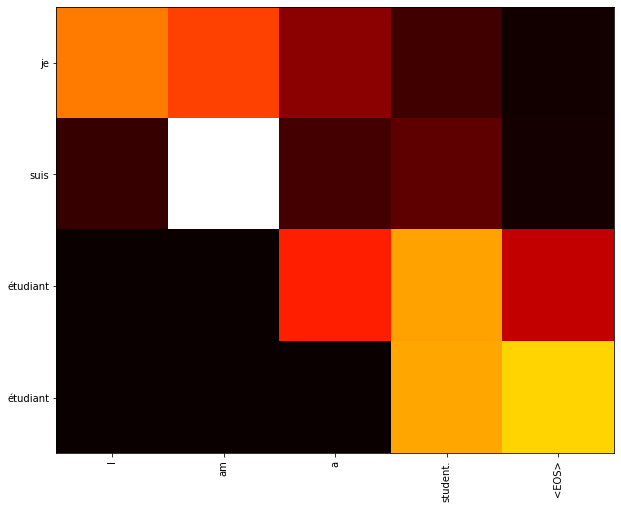

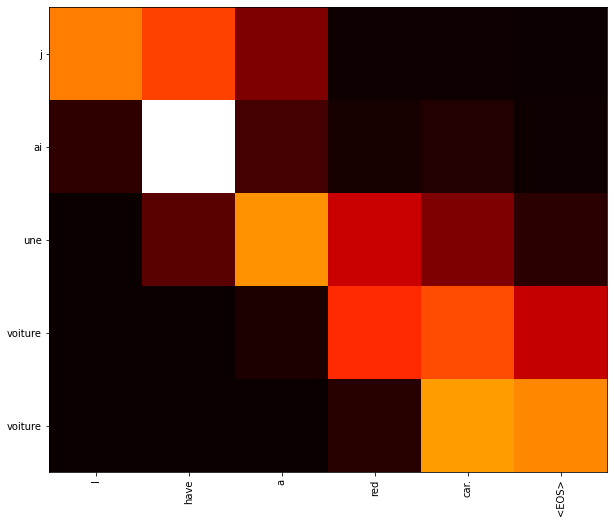

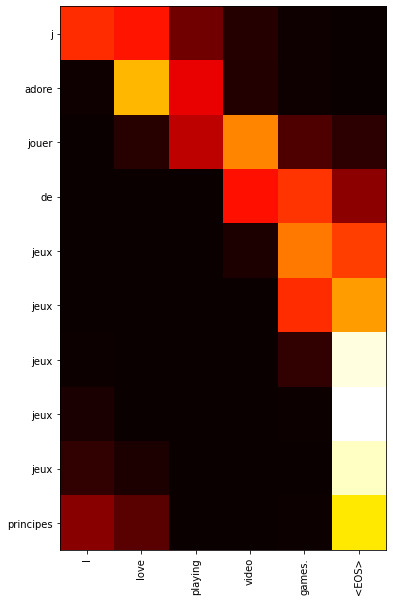

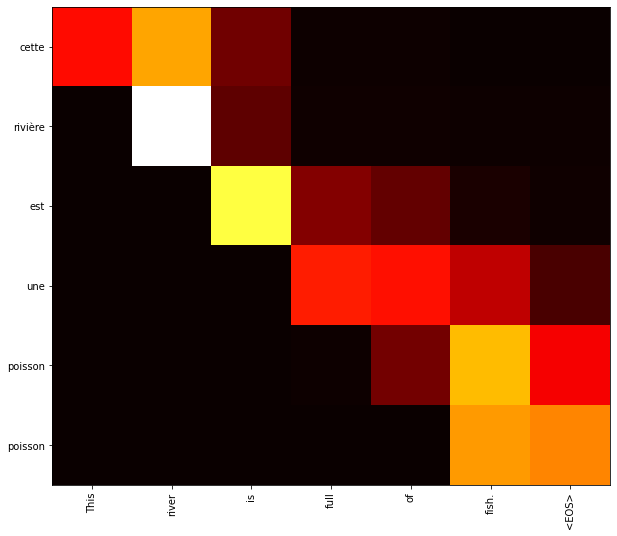

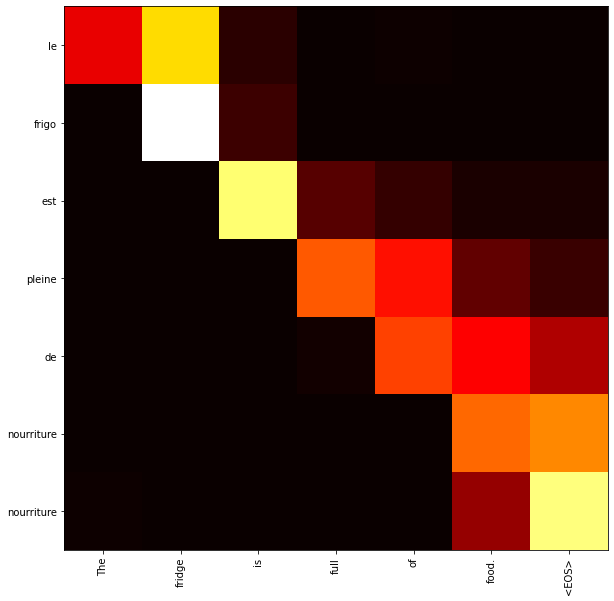

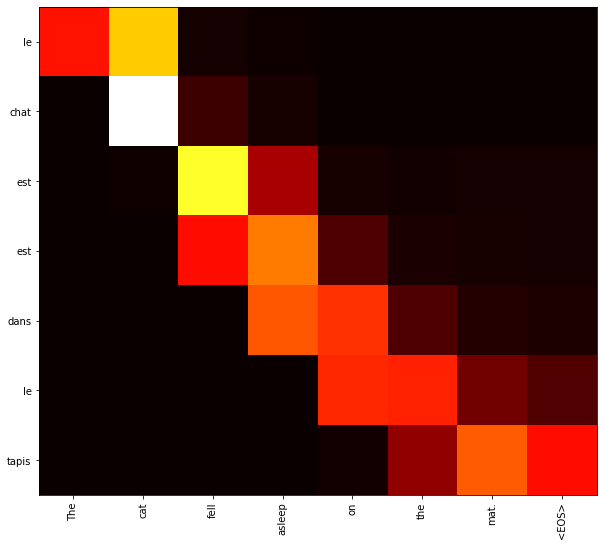

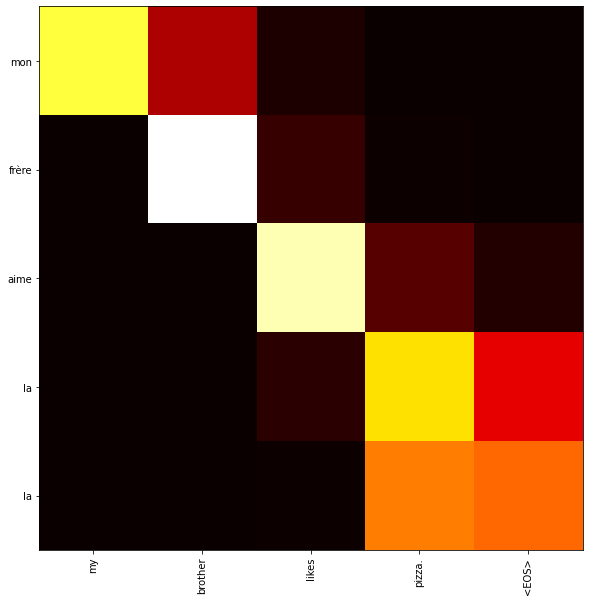

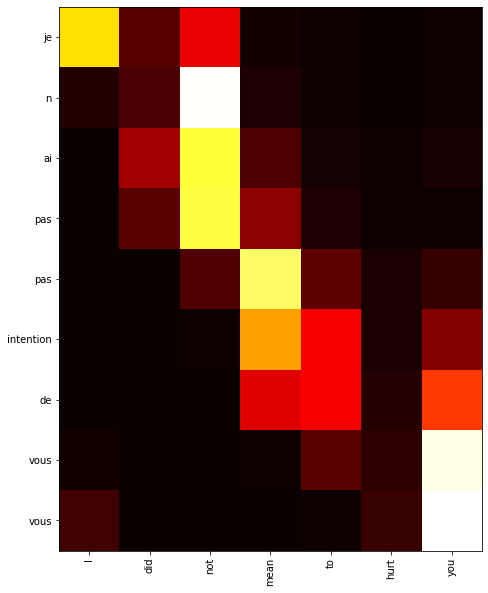

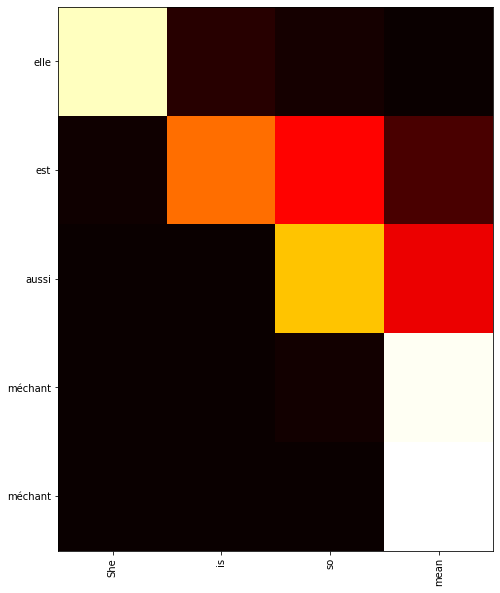

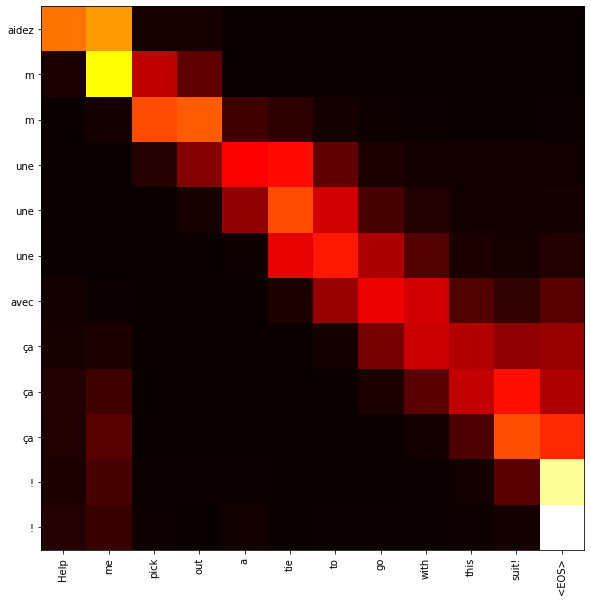

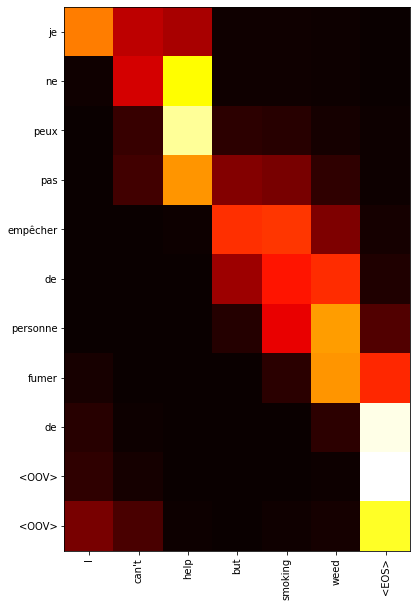

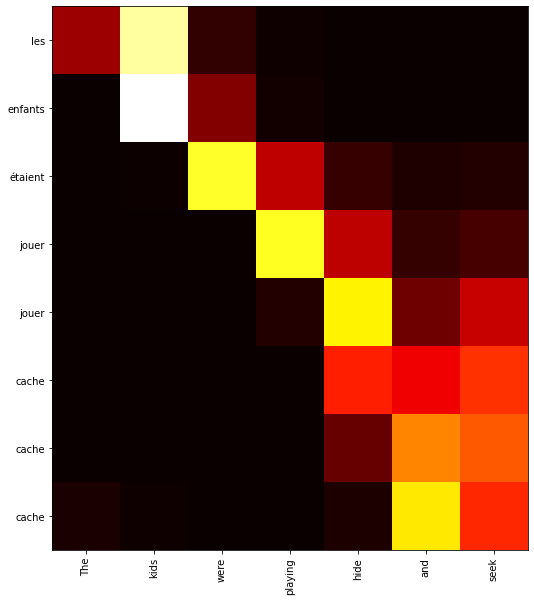

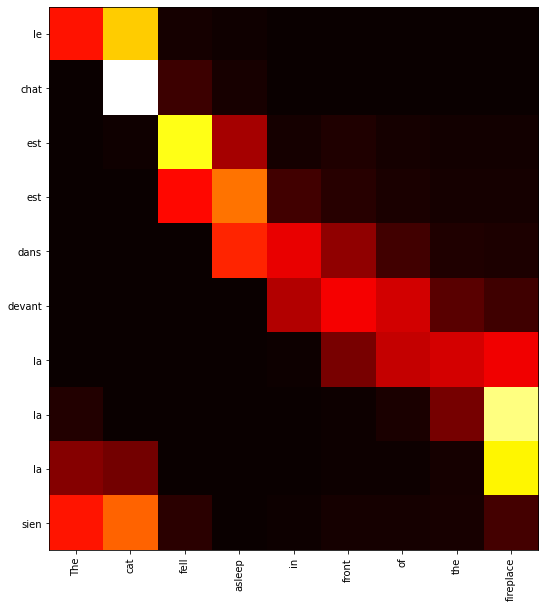

In [34]:
experiment(is_prod=True,do_att=True,do_tf=False,eos=False,n_epochs=15)

In [39]:
!zip -r "/content/models.zip" "/content/LAB2/models"
from google.colab import files
files.download('/content/models.zip') 

  adding: content/LAB2/models/ (stored 0%)
  adding: content/LAB2/models/model__att__tf.pt (deflated 11%)
  adding: content/LAB2/models/pretrained_moodle.pt (deflated 11%)
  adding: content/LAB2/models/experiment_att__tf.txt (deflated 54%)
  adding: content/LAB2/models/experiment.txt (deflated 53%)
  adding: content/LAB2/models/model_.pt (deflated 11%)
  adding: content/LAB2/models/model__att__no_eos.pt (deflated 11%)
  adding: content/LAB2/models/model__att_.pt (deflated 11%)
  adding: content/LAB2/models/experiment_att__no_eos.txt (deflated 54%)
  adding: content/LAB2/models/experiment_att_.txt (deflated 55%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>